In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [155]:
# from google.colab import drive
# drive.mount('/content/drive')

#Importation et familiarisation avec le jeu de données

In [156]:
df = pd.read_csv('./SWaT_dataset_Jul_19_v2.csv')
#df = pd.read_csv('drive/MyDrive/PDD/SWaT_dataset_Jul_19_v2.csv')
#df = pd.read_csv('drive/MyDrive/ProtectionDeDonnees/SWaT_dataset_Jul_19_v2.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,74,75,76,77) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [157]:
df.head()

,Unnamed: 0,P1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,P2,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,P3,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,P4,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,P5,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,P6,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77
0,GMT +0,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,FIT 201,LS 201,LS 202,LSL 203,LSLL 203,MV201,P2_STATE,P201 Status,P202 Status,P203 Status,P204 Status,P205 Status,P206 Status,P207 Status,P208 Status,AIT 301,AIT 302,AIT 303,DPIT 301,FIT 301,LIT 301,MV 301,MV 302,MV 303,MV 304,P3_STATE,P301 Status,P302 Status,AIT 401,AIT 402,FIT 401,LIT 401,LS 401,P4_STATE,P401 Status,P402 Status,P403 Status,P404 Status,UV401,AIT 501,AIT 502,AIT 503,AIT 504,FIT 501,FIT 502,FIT 503,FIT 504,MV 501,MV 502,MV 503,MV 504,P5_STATE,P501 Status,P502 Status,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
1,timestamp,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value
2,2019-07-20T04:30:00Z,0,729.8658,1,3,2,1,142.527557,9.293002,198.077423,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,730.7021,1,1,1,1,99,1,1,0,87.9518051,0.7817402,1000.62805,Inactive,4,2,1,1,1,2,7.4896183,147.3981,1016.27789,46.0651131,0.781594455,0.3103625,0.6236277,0.2134324,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1
3,2019-07-20T04:30:01Z,0,729.434,1,3,2,1,142.527557,9.293002,198.385025,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,730.902344,1,1,1,1,99,1,1,0,87.82363,0.782380462,1000.55115,Inactive,4,2,1,1,1,2,7.4896183,147.3981,1016.27789,45.7575,0.7822353,0.315101832,0.6236277,0.212984011,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1
4,2019-07-20T04:30:02.004013Z,0,729.12,1,3,2,1,142.527557,9.293002,198.4363,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,732.3443,1,1,1,1,99,1,1,0,87.7980042,0.7830207,1000.282,Inactive,4,2,1,1,1,2,7.4896183,147.3981,1016.27789,45.60369,0.7822353,0.3170232,0.6236277,0.212984011,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1


On met les bons noms de colones

In [158]:
df.columns = df.loc[0]

In [159]:
df.head()

,GMT +0,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,FIT 201,LS 201,LS 202,LSL 203,LSLL 203,MV201,P2_STATE,P201 Status,P202 Status,P203 Status,P204 Status,P205 Status,P206 Status,P207 Status,P208 Status,AIT 301,AIT 302,AIT 303,DPIT 301,FIT 301,LIT 301,MV 301,MV 302,MV 303,MV 304,P3_STATE,P301 Status,P302 Status,AIT 401,AIT 402,FIT 401,LIT 401,LS 401,P4_STATE,P401 Status,P402 Status,P403 Status,P404 Status,UV401,AIT 501,AIT 502,AIT 503,AIT 504,FIT 501,FIT 502,FIT 503,FIT 504,MV 501,MV 502,MV 503,MV 504,P5_STATE,P501 Status,P502 Status,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
0,GMT +0,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,FIT 201,LS 201,LS 202,LSL 203,LSLL 203,MV201,P2_STATE,P201 Status,P202 Status,P203 Status,P204 Status,P205 Status,P206 Status,P207 Status,P208 Status,AIT 301,AIT 302,AIT 303,DPIT 301,FIT 301,LIT 301,MV 301,MV 302,MV 303,MV 304,P3_STATE,P301 Status,P302 Status,AIT 401,AIT 402,FIT 401,LIT 401,LS 401,P4_STATE,P401 Status,P402 Status,P403 Status,P404 Status,UV401,AIT 501,AIT 502,AIT 503,AIT 504,FIT 501,FIT 502,FIT 503,FIT 504,MV 501,MV 502,MV 503,MV 504,P5_STATE,P501 Status,P502 Status,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
1,timestamp,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value,value
2,2019-07-20T04:30:00Z,0,729.8658,1,3,2,1,142.527557,9.293002,198.077423,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,730.7021,1,1,1,1,99,1,1,0,87.9518051,0.7817402,1000.62805,Inactive,4,2,1,1,1,2,7.4896183,147.3981,1016.27789,46.0651131,0.781594455,0.3103625,0.6236277,0.2134324,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1
3,2019-07-20T04:30:01Z,0,729.434,1,3,2,1,142.527557,9.293002,198.385025,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,730.902344,1,1,1,1,99,1,1,0,87.82363,0.782380462,1000.55115,Inactive,4,2,1,1,1,2,7.4896183,147.3981,1016.27789,45.7575,0.7822353,0.315101832,0.6236277,0.212984011,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1
4,2019-07-20T04:30:02.004013Z,0,729.12,1,3,2,1,142.527557,9.293002,198.4363,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,732.3443,1,1,1,1,99,1,1,0,87.7980042,0.7830207,1000.282,Inactive,4,2,1,1,1,2,7.4896183,147.3981,1016.27789,45.60369,0.7822353,0.3170232,0.6236277,0.212984011,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1


On supprime les lignes inutiles

In [160]:
df = df.drop([0,1], axis=0)

In [161]:
df.head()

,GMT +0,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,FIT 201,LS 201,LS 202,LSL 203,LSLL 203,MV201,P2_STATE,P201 Status,P202 Status,P203 Status,P204 Status,P205 Status,P206 Status,P207 Status,P208 Status,AIT 301,AIT 302,AIT 303,DPIT 301,FIT 301,LIT 301,MV 301,MV 302,MV 303,MV 304,P3_STATE,P301 Status,P302 Status,AIT 401,AIT 402,FIT 401,LIT 401,LS 401,P4_STATE,P401 Status,P402 Status,P403 Status,P404 Status,UV401,AIT 501,AIT 502,AIT 503,AIT 504,FIT 501,FIT 502,FIT 503,FIT 504,MV 501,MV 502,MV 503,MV 504,P5_STATE,P501 Status,P502 Status,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
2,2019-07-20T04:30:00Z,0,729.8658,1,3,2,1,142.527557,9.293002,198.077423,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,730.7021,1,1,1,1,99,1,1,0,87.9518051,0.7817402,1000.62805,Inactive,4,2,1,1,1,2,7.4896183,147.3981,1016.27789,46.0651131,0.781594455,0.3103625,0.6236277,0.2134324,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1
3,2019-07-20T04:30:01Z,0,729.434,1,3,2,1,142.527557,9.293002,198.385025,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,730.902344,1,1,1,1,99,1,1,0,87.82363,0.782380462,1000.55115,Inactive,4,2,1,1,1,2,7.4896183,147.3981,1016.27789,45.7575,0.7822353,0.315101832,0.6236277,0.212984011,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1
4,2019-07-20T04:30:02.004013Z,0,729.12,1,3,2,1,142.527557,9.293002,198.4363,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,732.3443,1,1,1,1,99,1,1,0,87.7980042,0.7830207,1000.282,Inactive,4,2,1,1,1,2,7.4896183,147.3981,1016.27789,45.60369,0.7822353,0.3170232,0.6236277,0.212984011,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1
5,2019-07-20T04:30:03.004013Z,0,728.6882,1,3,2,1,142.527557,9.289157,198.667,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,732.7048,1,1,1,1,99,1,1,0,87.6954651,0.7830207,1000.74341,Inactive,4,2,1,1,1,2,7.4896183,147.167389,1016.27789,45.60369,0.783132553,0.3080569,0.6236277,0.212791845,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1
6,2019-07-20T04:30:04Z,0,727.7069,1,3,2,1,142.527557,9.289157,198.89772,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,732.7448,1,1,1,1,99,1,1,0,87.61856,0.781228,1000.39734,Inactive,4,2,1,1,1,2,7.4896183,147.090485,1016.27789,45.2191734,0.7837734,0.303445637,0.6236277,0.2140089,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1


Mise a jour des index

In [162]:
df.reset_index(inplace=True, drop=True)

In [163]:
df.head()

,GMT +0,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,FIT 201,LS 201,LS 202,LSL 203,LSLL 203,MV201,P2_STATE,P201 Status,P202 Status,P203 Status,P204 Status,P205 Status,P206 Status,P207 Status,P208 Status,AIT 301,AIT 302,AIT 303,DPIT 301,FIT 301,LIT 301,MV 301,MV 302,MV 303,MV 304,P3_STATE,P301 Status,P302 Status,AIT 401,AIT 402,FIT 401,LIT 401,LS 401,P4_STATE,P401 Status,P402 Status,P403 Status,P404 Status,UV401,AIT 501,AIT 502,AIT 503,AIT 504,FIT 501,FIT 502,FIT 503,FIT 504,MV 501,MV 502,MV 503,MV 504,P5_STATE,P501 Status,P502 Status,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
0,2019-07-20T04:30:00Z,0,729.8658,1,3,2,1,142.527557,9.293002,198.077423,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,730.7021,1,1,1,1,99,1,1,0,87.9518051,0.7817402,1000.62805,Inactive,4,2,1,1,1,2,7.4896183,147.3981,1016.27789,46.0651131,0.781594455,0.3103625,0.6236277,0.2134324,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1
1,2019-07-20T04:30:01Z,0,729.434,1,3,2,1,142.527557,9.293002,198.385025,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,730.902344,1,1,1,1,99,1,1,0,87.82363,0.782380462,1000.55115,Inactive,4,2,1,1,1,2,7.4896183,147.3981,1016.27789,45.7575,0.7822353,0.315101832,0.6236277,0.212984011,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1
2,2019-07-20T04:30:02.004013Z,0,729.12,1,3,2,1,142.527557,9.293002,198.4363,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,732.3443,1,1,1,1,99,1,1,0,87.7980042,0.7830207,1000.282,Inactive,4,2,1,1,1,2,7.4896183,147.3981,1016.27789,45.60369,0.7822353,0.3170232,0.6236277,0.212984011,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1
3,2019-07-20T04:30:03.004013Z,0,728.6882,1,3,2,1,142.527557,9.289157,198.667,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,732.7048,1,1,1,1,99,1,1,0,87.6954651,0.7830207,1000.74341,Inactive,4,2,1,1,1,2,7.4896183,147.167389,1016.27789,45.60369,0.783132553,0.3080569,0.6236277,0.212791845,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1
4,2019-07-20T04:30:04Z,0,727.7069,1,3,2,1,142.527557,9.289157,198.89772,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,732.7448,1,1,1,1,99,1,1,0,87.61856,0.781228,1000.39734,Inactive,4,2,1,1,1,2,7.4896183,147.090485,1016.27789,45.2191734,0.7837734,0.303445637,0.6236277,0.2140089,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1


On modifie le nom de la colone temps

In [164]:
df = df.rename(columns={"GMT +0":"timestamp"})

On modifie cette colone en ne gardant que l'heure, les minutes et les secondes et on stocke sous format timedelta

!! A voir si il faut pas garder aussi les millisecondes et les micro secondes !!

In [165]:
import re
from datetime import timedelta

In [166]:
date_pattern = '[0-9]{2}:[0-9]{2}:[0-9]*'
i=0
for date in df['timestamp']:
    hour = re.findall(date_pattern, date)
    h = str(hour)[2:10]
    n = h.split(':')
    df['timestamp'][i] = timedelta(hours=int(n[0]), minutes=int(n[1]), seconds=int(n[2]))
    i+=1

In [167]:
df.head()

,timestamp,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,FIT 201,LS 201,LS 202,LSL 203,LSLL 203,MV201,P2_STATE,P201 Status,P202 Status,P203 Status,P204 Status,P205 Status,P206 Status,P207 Status,P208 Status,AIT 301,AIT 302,AIT 303,DPIT 301,FIT 301,LIT 301,MV 301,MV 302,MV 303,MV 304,P3_STATE,P301 Status,P302 Status,AIT 401,AIT 402,FIT 401,LIT 401,LS 401,P4_STATE,P401 Status,P402 Status,P403 Status,P404 Status,UV401,AIT 501,AIT 502,AIT 503,AIT 504,FIT 501,FIT 502,FIT 503,FIT 504,MV 501,MV 502,MV 503,MV 504,P5_STATE,P501 Status,P502 Status,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status
0,4:30:00,0,729.8658,1,3,2,1,142.527557,9.293002,198.077423,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,730.7021,1,1,1,1,99,1,1,0,87.9518051,0.7817402,1000.62805,Inactive,4,2,1,1,1,2,7.4896183,147.3981,1016.27789,46.0651131,0.781594455,0.3103625,0.6236277,0.2134324,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1
1,4:30:01,0,729.434,1,3,2,1,142.527557,9.293002,198.385025,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,730.902344,1,1,1,1,99,1,1,0,87.82363,0.782380462,1000.55115,Inactive,4,2,1,1,1,2,7.4896183,147.3981,1016.27789,45.7575,0.7822353,0.315101832,0.6236277,0.212984011,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1
2,4:30:02,0,729.12,1,3,2,1,142.527557,9.293002,198.4363,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,732.3443,1,1,1,1,99,1,1,0,87.7980042,0.7830207,1000.282,Inactive,4,2,1,1,1,2,7.4896183,147.3981,1016.27789,45.60369,0.7822353,0.3170232,0.6236277,0.212984011,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1
3,4:30:03,0,728.6882,1,3,2,1,142.527557,9.289157,198.667,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,732.7048,1,1,1,1,99,1,1,0,87.6954651,0.7830207,1000.74341,Inactive,4,2,1,1,1,2,7.4896183,147.167389,1016.27789,45.60369,0.783132553,0.3080569,0.6236277,0.212791845,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1
4,4:30:04,0,727.7069,1,3,2,1,142.527557,9.289157,198.89772,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,732.7448,1,1,1,1,99,1,1,0,87.61856,0.781228,1000.39734,Inactive,4,2,1,1,1,2,7.4896183,147.090485,1016.27789,45.2191734,0.7837734,0.303445637,0.6236277,0.2140089,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1


On creer les colones qui serviront pour labeliser les attaques
Pour l'instant que des 0

In [168]:
df['FIT401_attack'] = pd.Series(np.zeros(len(df)).astype(int))
df['LIT301_attack'] = pd.Series(np.zeros(len(df)).astype(int))
df['P601_attack'] = pd.Series(np.zeros(len(df)).astype(int))
df['MultiPoint_attack'] = pd.Series(np.zeros(len(df)).astype(int))
df['MV501_attack'] = pd.Series(np.zeros(len(df)).astype(int))
df['P301_attack'] = pd.Series(np.zeros(len(df)).astype(int))

In [169]:
df.head()

,timestamp,FIT 101,LIT 101,MV 101,P1_STATE,P101 Status,P102 Status,AIT 201,AIT 202,AIT 203,FIT 201,LS 201,LS 202,LSL 203,LSLL 203,MV201,P2_STATE,P201 Status,P202 Status,P203 Status,P204 Status,P205 Status,P206 Status,P207 Status,P208 Status,AIT 301,AIT 302,AIT 303,DPIT 301,FIT 301,LIT 301,MV 301,MV 302,MV 303,MV 304,P3_STATE,P301 Status,P302 Status,AIT 401,AIT 402,...,P401 Status,P402 Status,P403 Status,P404 Status,UV401,AIT 501,AIT 502,AIT 503,AIT 504,FIT 501,FIT 502,FIT 503,FIT 504,MV 501,MV 502,MV 503,MV 504,P5_STATE,P501 Status,P502 Status,PIT 501,PIT 502,PIT 503,FIT 601,LSH 601,LSH 602,LSH 603,LSL 601,LSL 602,LSL 603,P6 STATE,P601 Status,P602 Status,P603 Status,FIT401_attack,LIT301_attack,P601_attack,MultiPoint_attack,MV501_attack,P301_attack
0,4:30:00,0,729.8658,1,3,2,1,142.527557,9.293002,198.077423,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,730.7021,1,1,1,1,99,1,1,0,87.9518051,...,2,1,1,1,2,7.4896183,147.3981,1016.27789,46.0651131,0.781594455,0.3103625,0.6236277,0.2134324,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1,0,0,0,0,0,0
1,4:30:01,0,729.434,1,3,2,1,142.527557,9.293002,198.385025,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,730.902344,1,1,1,1,99,1,1,0,87.82363,...,2,1,1,1,2,7.4896183,147.3981,1016.27789,45.7575,0.7822353,0.315101832,0.6236277,0.212984011,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1,0,0,0,0,0,0
2,4:30:02,0,729.12,1,3,2,1,142.527557,9.293002,198.4363,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,732.3443,1,1,1,1,99,1,1,0,87.7980042,...,2,1,1,1,2,7.4896183,147.3981,1016.27789,45.60369,0.7822353,0.3170232,0.6236277,0.212984011,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1,0,0,0,0,0,0
3,4:30:03,0,728.6882,1,3,2,1,142.527557,9.289157,198.667,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,732.7048,1,1,1,1,99,1,1,0,87.6954651,...,2,1,1,1,2,7.4896183,147.167389,1016.27789,45.60369,0.783132553,0.3080569,0.6236277,0.212791845,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1,0,0,0,0,0,0
4,4:30:04,0,727.7069,1,3,2,1,142.527557,9.289157,198.89772,2.335437,Inactive,Inactive,Inactive,Inactive,2,2,1,1,2,1,2,1,1,1,8.522921,256.431274,143.158966,1.19085729,0.000512443,732.7448,1,1,1,1,99,1,1,0,87.61856,...,2,1,1,1,2,7.4896183,147.090485,1016.27789,45.2191734,0.7837734,0.303445637,0.6236277,0.2140089,2,2,1,1,12,2,1,167.601257,2.96350884,119.921173,0.000320379,Active,Active,Inactive,Inactive,Inactive,Active,2,1,1,1,0,0,0,0,0,0


### - Labelisation des données representant les 6 attaques

On déclare les debuts et fins des differentes attaques
A noter que les heures indiqué dans le pdf expliquant le déroulement des attaques sont à GMT +8 de celles du csv

In [170]:
deb_FIT401 = timedelta(hours=7, minutes=8, seconds=46)
fin_FIT401 = timedelta(hours=7, minutes=10, seconds=31)

deb_LIT301 = timedelta(hours=7, minutes=15, seconds=0)
fin_LIT301 = timedelta(hours=7, minutes=19, seconds=32)

deb_P601 = timedelta(hours=7, minutes=26, seconds=57)
fin_P601 = timedelta(hours=7, minutes=30, seconds=48)

deb_MultiPoint = timedelta(hours=7, minutes=38, seconds=50)
fin_MultiPoint = timedelta(hours=7, minutes=46, seconds=20)

deb_MV501 = timedelta(hours=7, minutes=54, seconds=0)
fin_MV501 = timedelta(hours=7, minutes=56, seconds=0)

deb_P301 = timedelta(hours=8, minutes=2, seconds=56)
fin_P301 = timedelta(hours=8, minutes=16, seconds=18)

Parcourt du dataframe pour labeliser les données selon les attaques

In [171]:
i = 0
for date in df['timestamp']:
    if(date > deb_FIT401 and date < fin_FIT401):
        df['FIT401_attack'][i] = 1
    if(date > deb_LIT301 and date < fin_LIT301):
        df['LIT301_attack'][i] = 1
    if(date > deb_P601 and date < fin_P601):
        df['P601_attack'][i] = 1
    if(date > deb_MultiPoint and date < fin_MultiPoint):
        df['MultiPoint_attack'][i] = 1
    if(date > deb_MV501 and date < fin_MV501):
        df['MV501_attack'][i] = 1
    if(date > deb_P301 and date < fin_P301):
        df['P301_attack'][i] = 1

    i += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: Sett

In [172]:
print("Nombre de données avec attaque sur FIT401 : " + str(len(df.loc[df['FIT401_attack'] == 1])))
print("Nombre de données avec attaque sur LIT301 : " + str(len(df.loc[df['LIT301_attack'] == 1])))
print("Nombre de données avec attaque sur P601 : " + str(len(df.loc[df['P601_attack'] == 1])))
print("Nombre de données avec attaque multi point : " + str(len(df.loc[df['MultiPoint_attack'] == 1])))
print("Nombre de données avec attaque sur MV501 : " + str(len(df.loc[df['MV501_attack'] == 1])))
print("Nombre de données avec attaque sur P301 : " + str(len(df.loc[df['P301_attack'] == 1])))

Nombre de données avec attaque sur FIT401 : 104
Nombre de données avec attaque sur LIT301 : 271
Nombre de données avec attaque sur P601 : 230
Nombre de données avec attaque multi point : 449
Nombre de données avec attaque sur MV501 : 119
Nombre de données avec attaque sur P301 : 801


# Data Observation

In [173]:
#Nombr de colonnes
nbCols = len(df.columns)
print("Nombre de colonnes dans le dataset: " + str(nbCols))

Nombre de colonnes dans le dataset: 84


In [174]:
#Noms des colonnes et leurs types
for i in df.columns:
  print(i + ", type: " + str(df.dtypes[i]))

timestamp, type: object
FIT 101, type: object
LIT 101, type: object
MV 101, type: object
P1_STATE, type: object
P101 Status, type: object
P102 Status, type: object
AIT 201, type: object
AIT 202, type: object
AIT 203, type: object
FIT 201, type: object
LS 201, type: object
LS 202, type: object
LSL 203, type: object
LSLL 203, type: object
MV201, type: object
P2_STATE, type: object
P201 Status, type: object
P202 Status, type: object
P203 Status, type: object
P204 Status, type: object
P205 Status, type: object
P206 Status, type: object
P207 Status, type: object
P208 Status, type: object
AIT 301, type: object
AIT 302, type: object
AIT 303, type: object
DPIT 301, type: object
FIT 301, type: object
LIT 301, type: object
MV 301, type: object
MV 302, type: object
MV 303, type: object
MV 304, type: object
P3_STATE, type: object
P301 Status, type: object
P302 Status, type: object
AIT 401, type: object
AIT 402, type: object
FIT 401, type: object
LIT 401, type: object
LS 401, type: object
P4_STATE,

In [175]:
#Taille du dataset
print("La taille du dataset est: " + str(len(df)))

La taille du dataset est: 14996


In [176]:
#Quels sont les attributs catégoriques?
#Dans le jeu de données original, toutes les colonnes avaient le type 'object'
#Mais en examinant les differentes valeurs possibles dans chacune des colonnes
#il nous semble que certaines colonnes sont bien catégoriques mais qu'il en 
#existe qui sont numériques

#Liste de colonnes qui nous semblent être catégoriques
cat_list = ['MV 101','P1_STATE','P101 Status','P102 Status','LS 201','LS 202',\
            'LSL 203','LSLL 203','MV201','P2_STATE','P201 Status','P202 Status',\
            'P203 Status','P204 Status','P205 Status','P206 Status','P207 Status',\
            'P208 Status','MV 301','MV 302','MV 303','MV 304','P3_STATE',\
            'P301 Status','P302 Status','LS 401','P4_STATE','P401 Status',\
            'P402 Status','P403 Status','P404 Status','UV401','MV 501','MV 502',\
            'MV 503','MV 504','P5_STATE','P501 Status','P502 Status','LSH 601',\
            'LSH 602','LSH 603','LSL 601','LSL 602','LSL 603','P6 STATE',\
            'P601 Status','P602 Status','P603 Status','FIT401_attack',\
            'LIT301_attack','P601_attack','MultiPoint_attack','MV501_attack',\
            'P301_attack']

#Liste de colonnes numériques
num_list = list(set(list(df.columns)) - set(cat_list))

#On enleve de la liste de colonnes numériques la colonne décrivant le temps
num_list.remove('timestamp')

In [177]:
#Pour chaque colonne catégorique on affiche les valeurs possibles
for i in cat_list:
  df[i] = df[i].astype(str).astype(object)
  print("Valeurs possibles de "+ str(i) + ": " + str(df[i].unique()))

Valeurs possibles de MV 101: ['1' '0' '2']
Valeurs possibles de P1_STATE: ['3' '2']
Valeurs possibles de P101 Status: ['2' '1']
Valeurs possibles de P102 Status: ['1']
Valeurs possibles de LS 201: ['Inactive']
Valeurs possibles de LS 202: ['Inactive']
Valeurs possibles de LSL 203: ['Inactive']
Valeurs possibles de LSLL 203: ['Inactive']
Valeurs possibles de MV201: ['2' '0' '1']
Valeurs possibles de P2_STATE: ['2']
Valeurs possibles de P201 Status: ['1']
Valeurs possibles de P202 Status: ['1']
Valeurs possibles de P203 Status: ['2' '1']
Valeurs possibles de P204 Status: ['1']
Valeurs possibles de P205 Status: ['2' '1']
Valeurs possibles de P206 Status: ['1']
Valeurs possibles de P207 Status: ['1']
Valeurs possibles de P208 Status: ['1']
Valeurs possibles de MV 301: ['1' '0' '2']
Valeurs possibles de MV 302: ['1' '0' '2']
Valeurs possibles de MV 303: ['1' '0' '2']
Valeurs possibles de MV 304: ['1' '0' '2']
Valeurs possibles de P3_STATE: ['99' '2' '4' '5' '6' '7' '9' '10' '14' '15' '16']


In [178]:
#Parmi les colonnes categoriques, nous allons enlever les colonnes ayant 
#uniquement une valeur
const_cat = []
for i in cat_list:
  l = len(df[i].unique())
  if (l == 1):
    print(str(i) + ", et la valeur est: " + str(df[i].unique()))
    df = df.drop(i, axis=1)
    const_cat.append(i)

#On enleve de la liste de colonnes categoriques toutes les colonnes constantes
cat_list = list(set(cat_list) - set(const_cat))

P102 Status, et la valeur est: ['1']
LS 201, et la valeur est: ['Inactive']
LS 202, et la valeur est: ['Inactive']
LSL 203, et la valeur est: ['Inactive']
LSLL 203, et la valeur est: ['Inactive']
P2_STATE, et la valeur est: ['2']
P201 Status, et la valeur est: ['1']
P202 Status, et la valeur est: ['1']
P204 Status, et la valeur est: ['1']
P206 Status, et la valeur est: ['1']
P207 Status, et la valeur est: ['1']
P208 Status, et la valeur est: ['1']
P302 Status, et la valeur est: ['1']
LS 401, et la valeur est: ['Inactive']
P4_STATE, et la valeur est: ['4']
P402 Status, et la valeur est: ['1']
P403 Status, et la valeur est: ['1']
P404 Status, et la valeur est: ['1']
MV 502, et la valeur est: ['2']
MV 503, et la valeur est: ['1']
MV 504, et la valeur est: ['1']
P5_STATE, et la valeur est: ['12']
P501 Status, et la valeur est: ['2']
P502 Status, et la valeur est: ['1']
LSH 602, et la valeur est: ['Active']
LSH 603, et la valeur est: ['Inactive']
LSL 601, et la valeur est: ['Inactive']
LSL 

In [179]:
#Ensuite pour les colonnes numériques nous aimerions afficher pour chaque 
#colonne, le minmum, le maximum, la moyenne, la mediane et l'ecart-type.
#Pour faire cela, nous devons d'abord changer le type de la colonne en float

for i in num_list:
    df[i] = df[i].astype(float)

for i in num_list:
    print(df[i].describe())

count    14996.000000
mean         0.798153
std          0.033274
min          0.457703
25%          0.799539
50%          0.801589
75%          0.802871
max          0.827736
Name: FIT 501, dtype: float64
count    14996.000000
mean         0.824523
std          0.856954
min          0.000000
25%          0.000512
50%          0.000641
75%          1.718220
max          1.856452
Name: FIT 301, dtype: float64
count    14996.000000
mean       160.706744
std          5.707502
min        158.132523
25%        159.526400
50%        160.231354
75%        160.695969
max        219.014359
Name: PIT 501, dtype: float64
count    14996.000000
mean       138.766501
std          8.265845
min        113.849014
25%        131.536789
50%        143.713150
75%        144.033585
max        146.821335
Name: AIT 201, dtype: float64
count    14996.000000
mean        69.268478
std          8.878605
min         61.394516
25%         65.957440
50%         68.982315
75%         69.982056
max        147.398100


In [180]:
#Parmi les colonnes numériques, nous allons enlever les colonnes ayant 
#uniquement une valeur
const_num = []
for i in num_list:
  l = len(df[i].unique())
  if (l == 1):
    print(str(i) + ", et la valeur est: " + str(df[i].unique()))
    df = df.drop(i, axis=1)
    const_num.append(i)

#On enleve de la liste de colonnes numeriques toutes les colonnes constantes
num_list = list(set(num_list) - set(const_num))

AIT 401, et la valeur est: [0.]


In [181]:
print(len(df.columns))

51


In [182]:
#On vérifie s'il y a des NaN dans les colonnes pour eventuellement les éliminer.
#Mais comme nous pouvons voir, il n'y en a pas
nan = False
cols = list(df.columns)
for i in cols:
    nan_number = df[i].isna().sum()
    if (nan_number > 0):
        print(str((nan_number/df.shape[0])*100)+'%')
        nan = True
        
if (nan == False):
    print('Il n\'y a pas de données manquantes')

Il n'y a pas de données manquantes


## Matrice de correlation

In [183]:
#Nous créons un dossier ou les matrices de correlation seront stockées
if not os.path.exists('./corrMat'):
  os.mkdir('./corrMat')

folderImg = './corrMat'

In [184]:
pre_attack = df.loc[df['timestamp'] < deb_FIT401]

pre_attack_correlation_mat = pre_attack.corr()
plt.figure(figsize=(11,9))
sns.heatmap(pre_attack_correlation_mat)

img = 'preAttack.png'
plt.savefig(os.path.join(folderImg, img))
#Pour ne pas afficher directement la matrice de correlation, on fait:
plt.close()

In [185]:
#Matrice de correlation pendant l'attaque sur FIT 401
pdtFit401Attack = df.loc[(df['timestamp'] > deb_FIT401) &\
                         (df['timestamp'] < fin_FIT401)]

pdtFit401Attack_corr = pdtFit401Attack.corr()
plt.figure(figsize=(11,9))
sns.heatmap(pdtFit401Attack_corr)

img = 'pdtFit401Attack.png'
plt.savefig(os.path.join(folderImg, img))
#Pour ne pas afficher directement la matrice de correlation, on fait:
plt.close()

In [186]:
#Matrice de correlation entre l'attaque sur FIT 401 et LIT 301
entreFit401_Lit301 = df.loc[(df['timestamp'] > fin_FIT401) &\
                            (df['timestamp'] < deb_LIT301)]
                        
entreFit401_Lit301_corr = entreFit401_Lit301.corr()
plt.figure(figsize=(11,9))
sns.heatmap(entreFit401_Lit301_corr)

img = 'entreFit401_Lit301.png'
plt.savefig(os.path.join(folderImg, img))
#Pour ne pas afficher directement la matrice de correlation, on fait:
plt.close()

In [187]:
#Matrice de correlation pendant l'attaque sur LIT 301
pdtLit301Attack = df.loc[(df['timestamp'] > deb_LIT301) &\
                         (df['timestamp'] < fin_LIT301)]

pdtLit301Attack_corr = pdtLit301Attack.corr()
plt.figure(figsize=(11,9))
sns.heatmap(pdtLit301Attack_corr)

img = 'pdtLit301Attack.png'
plt.savefig(os.path.join(folderImg, img))
#Pour ne pas afficher directement la matrice de correlation, on fait:
plt.close()

In [188]:
#Matrice de correlation entre l'attaque sur LIT 301 et P601
entreLit301_P601 = df.loc[(df['timestamp'] > fin_LIT301) &\
                            (df['timestamp'] < deb_P601)]
                        
entreLit301_P601_corr = entreLit301_P601.corr()
plt.figure(figsize=(11,9))
sns.heatmap(entreLit301_P601_corr)

img = 'entreLit301_P601.png'
plt.savefig(os.path.join(folderImg, img))
#Pour ne pas afficher directement la matrice de correlation, on fait:
plt.close()

In [189]:
#Matrice de correlation pendant l'attaque sur P601
pdtP601Attack = df.loc[(df['timestamp'] > deb_P601) &\
                         (df['timestamp'] < fin_P601)]

pdtP601Attack_corr = pdtP601Attack.corr()
plt.figure(figsize=(11,9))
sns.heatmap(pdtP601Attack_corr)

img = 'pdtP601Attack.png'
plt.savefig(os.path.join(folderImg, img))
#Pour ne pas afficher directement la matrice de correlation, on fait:
plt.close()

In [190]:
#Matrice de correlation entre l'attaque sur P601 et l'ataque MultiPoint
entreP601_Mp = df.loc[(df['timestamp'] > fin_P601) &\
                            (df['timestamp'] < deb_MultiPoint)]
                        
entreP601_Mp_corr = entreP601_Mp.corr()
plt.figure(figsize=(11,9))
sns.heatmap(entreP601_Mp_corr)

img = 'entreP601_Mp.png'
plt.savefig(os.path.join(folderImg, img))
#Pour ne pas afficher directement la matrice de correlation, on fait:
plt.close()

In [191]:
#Matrice de correlation pendant l'attaque MultiPoint
pdtMultiPointAttack = df.loc[(df['timestamp'] > deb_MultiPoint) &\
                         (df['timestamp'] < fin_MultiPoint)]

pdtMultiPointAttack_corr = pdtMultiPointAttack.corr()
plt.figure(figsize=(11,9))
sns.heatmap(pdtMultiPointAttack_corr)

img = 'pdtMultiPointAttack.png'
plt.savefig(os.path.join(folderImg, img))
#Pour ne pas afficher directement la matrice de correlation, on fait:
plt.close()

In [192]:
#Matrice de correlation entre l'attaque Multi Point et l'attaque sur MV501
entreMp_MV501 = df.loc[(df['timestamp'] > fin_MultiPoint) &\
                            (df['timestamp'] < deb_MV501)]
                        
entreMp_MV501_corr = entreMp_MV501.corr()
plt.figure(figsize=(11,9))
sns.heatmap(entreMp_MV501_corr)

img = 'entreMp_MV501.png'
plt.savefig(os.path.join(folderImg, img))
#Pour ne pas afficher directement la matrice de correlation, on fait:
plt.close()

In [193]:
#Matrice de correlation pendant l'attaque MV501
pdtMV501Attack = df.loc[(df['timestamp'] > deb_MV501) &\
                         (df['timestamp'] < fin_MV501)]

pdtMV501Attack_corr = pdtMV501Attack.corr()
plt.figure(figsize=(11,9))
sns.heatmap(pdtMV501Attack_corr)

img = 'pdtMV501Attack.png'
plt.savefig(os.path.join(folderImg, img))
#Pour ne pas afficher directement la matrice de correlation, on fait:
plt.close()

In [194]:
#Matrice de correlation entre l'attaque sur MV501 et sur P301
entreMV501_P301 = df.loc[(df['timestamp'] > fin_MV501) &\
                            (df['timestamp'] < deb_P301)]
                        
entreMV501_P301_corr = entreMV501_P301.corr()
plt.figure(figsize=(11,9))
sns.heatmap(entreMV501_P301_corr)

img = 'entreMV501_P301.png'
plt.savefig(os.path.join(folderImg, img))
#Pour ne pas afficher directement la matrice de correlation, on fait:
plt.close()

In [195]:
#Matrice de correlation pendant l'attaque sur P301
pdtP301Attack = df.loc[(df['timestamp'] > deb_P301) &\
                         (df['timestamp'] < fin_P301)]

pdtP301Attack_corr = pdtP301Attack.corr()
plt.figure(figsize=(11,9))
sns.heatmap(pdtP301Attack_corr)

img = 'pdtP301Attack.png'
plt.savefig(os.path.join(folderImg, img))
#Pour ne pas afficher directement la matrice de correlation, on fait:
plt.close()

In [196]:
#Matrice de correlation apres toutes les attaques
apresAttack = df.loc[df['timestamp']> fin_P301]

apresAttack_corr = apresAttack.corr()
plt.figure(figsize=(11,9))
sns.heatmap(apresAttack_corr)

img = 'apresAttack.png'
plt.savefig(os.path.join(folderImg, img))
#Pour ne pas afficher directement la matrice de correlation, on fait:
plt.close()

In [197]:
#Matrice de correlation, toutes les données avec les labels d'attaques
bla = df.copy()
bla['FIT401_attack'] = bla['FIT401_attack'].astype(float)
bla['LIT301_attack'] = bla['LIT301_attack'].astype(float)
bla['P601_attack'] = bla['P601_attack'].astype(float)
bla['MultiPoint_attack'] = bla['MultiPoint_attack'].astype(float)
bla['MV501_attack'] = bla['MV501_attack'].astype(float)
bla['P301_attack'] = bla['P301_attack'].astype(float)

print(bla['FIT401_attack'].dtypes)
bla_corr = bla.corr()
plt.figure(figsize=(11,9))
sns.heatmap(bla_corr)

img = 'toutesDonnesAvecLabel.png'
plt.savefig(os.path.join(folderImg, img))
#Pour ne pas afficher directement la matrice de correlation, on fait:
plt.close()

float64


#Plot des graphiques avec affichages des timezones d'attaques (données décalées)

In [198]:
import matplotlib.dates as mdates
_deb_FIT401 = deb_FIT401
_fin_FIT401 = fin_FIT401

_deb_LIT301 = deb_LIT301
_fin_LIT301 = fin_LIT301

_deb_P601 = deb_P601
_fin_P601 = fin_P601

_deb_MultiPoint = deb_MultiPoint
_fin_MultiPoint = fin_MultiPoint

_deb_MV501 = deb_MV501
_fin_MV501 = fin_MV501

_deb_P301 = deb_P301
_fin_P301 = fin_P301

# specify a date to use for the times
zero = pd.datetime(1,1,1)
time = [zero + t for t in df['timestamp']]


_deb_FIT401 += zero
_fin_FIT401 += zero

_deb_LIT301 += zero
_fin_LIT301 += zero

_deb_P601 += zero
_fin_P601 += zero

_deb_MultiPoint += zero
_fin_MultiPoint += zero

_deb_MV501 += zero
_fin_MV501 += zero

_deb_P301 += zero
_fin_P301 += zero

# convert datetimes to numbers
zero = mdates.date2num(zero)
time = [t-zero for t in mdates.date2num(time)]
_deb_FIT401 = mdates.date2num(_deb_FIT401) - zero
_fin_FIT401 = mdates.date2num(_fin_FIT401) - zero

_deb_LIT301 = mdates.date2num(_deb_LIT301) - zero
_fin_LIT301 = mdates.date2num(_fin_LIT301) - zero

_deb_P601 = mdates.date2num(_deb_P601) - zero
_fin_P601 = mdates.date2num(_fin_P601) - zero

_deb_MultiPoint = mdates.date2num(_deb_MultiPoint) - zero
_fin_MultiPoint = mdates.date2num(_fin_MultiPoint) - zero

_deb_MV501 = mdates.date2num(_deb_MV501) - zero
_fin_MV501 = mdates.date2num(_fin_MV501) - zero

_deb_P301 = mdates.date2num(_deb_P301) - zero
_fin_P301 = mdates.date2num(_fin_P301) - zero

#define grid of plots
fig, axs = plt.subplots(nrows=len(num_list), ncols=1, figsize=(30,300))

#add data to plots
for i in range(0,len(num_list)):
    axs[i].title.set_text(num_list[i])
    axs[i].plot_date(time, df[num_list[i]],'b-')
    axs[i].axvspan(_deb_FIT401,_fin_FIT401, facecolor='pink',alpha=0.3)# FIT401 atk
    axs[i].axvspan(_deb_LIT301,_fin_LIT301, facecolor='pink',alpha=0.3)# LIT301_atk
    axs[i].axvspan(_deb_P601,_fin_P601, facecolor='pink',alpha=0.3)# P601_atk
    axs[i].axvspan(_deb_MultiPoint,_fin_MultiPoint, facecolor='pink',alpha=0.3)# Multipoint_atk
    axs[i].axvspan(_deb_MV501,_fin_MV501, facecolor='pink',alpha=0.3)# MV501_atk
    axs[i].axvspan(_deb_P301,_fin_P301, facecolor='pink',alpha=0.3)# P301_atk



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f0f844c1cb0> (for post_execute):


ValueError: ignored

ValueError: ignored

#Correction des labels avec determination du bon debut et fin de chaque attaque

In [199]:
#Les vrais débuts et fins des attaques, trouvé à la main

#Attaque sur FIT 401
#Debut ligne 9416, fin ligne 9520
real_deb_FIT401 = timedelta(hours=7, minutes=6, seconds=59)
real_fin_FIT401 = timedelta(hours=7, minutes=8, seconds=45)

#Attaque sur LIT 301
#Debut ligne 9803, fin ligne 10063
real_deb_LIT301 = timedelta(hours=7, minutes=13, seconds=26)
real_fin_LIT301 = timedelta(hours=7, minutes=17, seconds=48)

#Attaque sur P601
#Debut ligne 10509, fin ligne 10738
real_deb_P601 = timedelta(hours=7, minutes=25, seconds=12)
real_fin_P601 = timedelta(hours=7, minutes=29, seconds=3)

#Attaque Multi Point
#Debut ligne 11228, fin ligne 11691
real_deb_MultiPoint = timedelta(hours=7, minutes=37, seconds=11)
real_fin_MultiPoint = timedelta(hours=7, minutes=44, seconds=56)

#Attaque sur MV 501
#Debut ligne 12141, fin ligne 12291
real_deb_MV501 = timedelta(hours=7, minutes=52, seconds=24)
real_fin_MV501 = timedelta(hours=7, minutes=54, seconds=56)

#Attaque sur P301
#Debut ligne 12662, fin ligne 13503
real_deb_P301 = timedelta(hours=8, minutes=1, seconds=5)
real_fin_P301 = timedelta(hours=8, minutes=15, seconds=8)

In [200]:
#On relabelise les données, cette fois ci correctement
cat_attack = ['FIT401_attack','LIT301_attack','P601_attack',\
              'MultiPoint_attack','MV501_attack','P301_attack']

#On transforme chaque colonne XXX_attack en colonne de 0
for c in cat_attack:
  df[c] = pd.Series(np.zeros(len(df)).astype(int))


#On relabelise
i = 0
for date in df['timestamp']:
    if(date > real_deb_FIT401 and date < real_fin_FIT401):
        df['FIT401_attack'][i] = 1
    if(date > real_deb_LIT301 and date < real_fin_LIT301):
        df['LIT301_attack'][i] = 1
    if(date > real_deb_P601 and date < real_fin_P601):
        df['P601_attack'][i] = 1
    if(date > real_deb_MultiPoint and date < real_fin_MultiPoint):
        df['MultiPoint_attack'][i] = 1
    if(date > real_deb_MV501 and date < real_fin_MV501):
        df['MV501_attack'][i] = 1
    if(date > real_deb_P301 and date < real_fin_P301):
        df['P301_attack'][i] = 1

    i += 1


#Pour finir, on change le type de colonnes de int vers object
for c in cat_attack:
  df[c] = df[c].astype(str).astype(object)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_laun

#Plot des graphiques avec affichages des timezones d'attaques (données correctes)

In [201]:
_deb_FIT401 = real_deb_FIT401
_fin_FIT401 = real_fin_FIT401

_deb_LIT301 = real_deb_LIT301
_fin_LIT301 = real_fin_LIT301

_deb_P601 = real_deb_P601
_fin_P601 = real_fin_P601

_deb_MultiPoint = real_deb_MultiPoint
_fin_MultiPoint = real_fin_MultiPoint

_deb_MV501 = real_deb_MV501
_fin_MV501 = real_fin_MV501

_deb_P301 = real_deb_P301
_fin_P301 = real_fin_P301

# specify a date to use for the times
zero = pd.datetime(1,1,1)
time = [zero + t for t in df['timestamp']]


_deb_FIT401 += zero
_fin_FIT401 += zero

_deb_LIT301 += zero
_fin_LIT301 += zero

_deb_P601 += zero
_fin_P601 += zero

_deb_MultiPoint += zero
_fin_MultiPoint += zero

_deb_MV501 += zero
_fin_MV501 += zero

_deb_P301 += zero
_fin_P301 += zero

# convert datetimes to numbers
zero = mdates.date2num(zero)
time = [t-zero for t in mdates.date2num(time)]
_deb_FIT401 = mdates.date2num(_deb_FIT401) - zero
_fin_FIT401 = mdates.date2num(_fin_FIT401) - zero

_deb_LIT301 = mdates.date2num(_deb_LIT301) - zero
_fin_LIT301 = mdates.date2num(_fin_LIT301) - zero

_deb_P601 = mdates.date2num(_deb_P601) - zero
_fin_P601 = mdates.date2num(_fin_P601) - zero

_deb_MultiPoint = mdates.date2num(_deb_MultiPoint) - zero
_fin_MultiPoint = mdates.date2num(_fin_MultiPoint) - zero

_deb_MV501 = mdates.date2num(_deb_MV501) - zero
_fin_MV501 = mdates.date2num(_fin_MV501) - zero

_deb_P301 = mdates.date2num(_deb_P301) - zero
_fin_P301 = mdates.date2num(_fin_P301) - zero

#define grid of plots
fig, axs = plt.subplots(nrows=len(num_list), ncols=1, figsize=(30,300))

#add data to plots
for i in range(0,len(num_list)):
    axs[i].title.set_text(num_list[i])
    axs[i].plot_date(time, df[num_list[i]],'b-')
    axs[i].axvspan(_deb_FIT401,_fin_FIT401, facecolor='pink',alpha=0.3)# FIT401 atk
    axs[i].axvspan(_deb_LIT301,_fin_LIT301, facecolor='pink',alpha=0.3)# LIT301_atk
    axs[i].axvspan(_deb_P601,_fin_P601, facecolor='pink',alpha=0.3)# P601_atk
    axs[i].axvspan(_deb_MultiPoint,_fin_MultiPoint, facecolor='pink',alpha=0.3)# Multipoint_atk
    axs[i].axvspan(_deb_MV501,_fin_MV501, facecolor='pink',alpha=0.3)# MV501_atk
    axs[i].axvspan(_deb_P301,_fin_P301, facecolor='pink',alpha=0.3)# P301_atk

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f0f844c1cb0> (for post_execute):


ValueError: ignored

ValueError: ignored

#Premier algorithme de detection d'anomalies: Isolation Forest

In [202]:
#On ajoute une colonne isAttack qui servira de label pour généraliser les 
#attaques. Si lors de l'observation, le systeme est attaqué (FIT401,
#LIT301 etc.), isAttack sera à 1, 0 sinon.
df['isAttack'] = ((df['FIT401_attack']=='1') | (df['LIT301_attack']=='1') | \
                  (df['P601_attack']=='1') | (df['MultiPoint_attack']=='1') |\
                  (df['MV501_attack']=='1') | (df['P301_attack']=='1'))
                                               
df['isAttack'] = df['isAttack'].replace({True:1, False:0})
df['isAttack'] = df['isAttack'].astype(str).astype(object)


In [203]:
#On définit X et Y qu'on utilisera pour fit le classifieur
X = df.drop(['timestamp','FIT401_attack','LIT301_attack','P601_attack','MultiPoint_attack',\
             'MV501_attack','P301_attack','isAttack'], axis=1)
Y = df[['isAttack']]

#On replace tous les espaces dans les noms des colonnes par des '_'
X.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)

In [204]:
#On one-hot toutes les colonnes catégoriques de X
cat_list_X = X.select_dtypes(include=['object'])

for i in cat_list_X:
  oneHotEnc = pd.get_dummies(X[i], prefix=i)
  X = pd.concat([X, oneHotEnc], axis=1)
  X = X.drop(i, axis=1)

In [205]:
#DEFINITION DES PARAMETRES DU MODELE
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(99)
#Dans le jeu de données, on a 2053 observations qui sont labélisées 1 sur
#'isAttack' et en tout nous avons 14996 observations donc ça fait 
#13.69032% de outliers
outlier_fraction=0.1369
nb_samples = len(df)

clf = IsolationForest(max_samples = nb_samples, contamination=outlier_fraction,\
                      random_state=rng)


In [206]:
#ENTRAINEMENT ET PREDICTION DU MODELE
clf.fit(X)
ifOutliers = clf.predict(X)

In [207]:
#EVALUATION DE L'EFFICACITE DE L'ALGO
compTab =  Y.copy()
compTab['ifOutliers'] = ifOutliers

nbAnomalies = len(compTab.loc[compTab['isAttack']=='1'])
nbTruePos = len(compTab.loc[(compTab['isAttack']=='1') &\
                            (compTab['ifOutliers']==-1)])
print("Le nombre d'anomalies au total est: " + str(nbAnomalies)+"\n")
print("Le nombre de vrais positifs est: " + str(nbTruePos)+ "\n")
print("Le taux de detections correctes est de: " + \
      str(nbTruePos*100/nbAnomalies) +"%\n")

Le nombre d'anomalies au total est: 2053

Le nombre de vrais positifs est: 683

Le taux de detections correctes est de: 33.26838772528008%



#Deuxieme algorithme de detection d'anomalies: LOF

In [208]:
#DEFINITION DES PARAMETRES DU MODELE
from sklearn.neighbors import LocalOutlierFactor

#On peut faire varier n_neighbors pour obtenir des taux de detection
#differents, pour 5000 le taux de detection etait le plus elevé
clf = LocalOutlierFactor(n_neighbors=5000)

In [209]:
#ENTRAINEMENT ET PREDICTION DU MODELE
lofOutliers = clf.fit_predict(X)

In [210]:
#EVALUATION DE L'EFFICACITE DE L'ALGO
compTab['lofOutliers'] = lofOutliers

nbTruePos = len(compTab.loc[(compTab['isAttack']=='1') &\
                            (compTab['lofOutliers']==-1)])
print("Le nombre d'anomalies au total est: " + str(nbAnomalies)+"\n")
print("Le nombre de vrais positifs est: " + str(nbTruePos)+ "\n")
print("Le taux de detections correctes est de: " + \
      str(nbTruePos*100/nbAnomalies) +"%\n")

Le nombre d'anomalies au total est: 2053

Le nombre de vrais positifs est: 283

Le taux de detections correctes est de: 13.784705309303458%



#Troisieme algorithme, prediction d'anomalies: XGBoost

##Entrainement et evaluation du modèle

In [211]:
#PREPARATION DES DONNEES
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,\
                                                    random_state=5)

In [212]:
#DEFINITION DES PARAMETRES DU MODELE
from xgboost import XGBClassifier
from numpy import sqrt 
#nbr d'observations non attaque divisé par le nombre d'observations lors
#d'une attaque. On ajoute ce poids pour équilibrer les données car dans notre
#jeu de donnés nous avons 2053 observations qui ont isAttack=1 et 12943 
#observations qui ont isAttack = 0.
weights = (Y['isAttack']=='0').sum() / (1.0 * (Y['isAttack']=='1').sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight=weights, n_jobs = 4)
xgbTestOutliers = clf.fit(X_train,y_train).predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [213]:
#EVALUATION DE L'EFFICACITE DE L'ALGO
compTab2 = y_test.copy()
compTab2['xgbTestOutliers'] = xgbTestOutliers

nbElts = len(y_test)
nbAnomaliesTest = len(y_test.loc[y_test['isAttack']=='1'])
nbTruePos = len(compTab2.loc[(compTab2['isAttack']=='1') &\
                             (compTab2['xgbTestOutliers']=='1')])
print("Le nombre d'elements dans y_test est: " + str(nbElts) +"\n")
print("Le nombre d'anomalies dans y_test est: " + str(nbAnomaliesTest) + "\n")
print("Le nombre d'anomalies detectées par XGBoost: " + str(nbTruePos) + "\n")

Le nombre d'elements dans y_test est: 3000

Le nombre d'anomalies dans y_test est: 384

Le nombre d'anomalies detectées par XGBoost: 382



In [218]:
# POURCENTAGE

print("Pourcentage d'anomalies détectées par XGBoost par rapport au nombre réel d'anomalie : " + str((nbTruePos/nbAnomaliesTest)*100) + "%")

Pourcentage d'anomalies détectées par XGBoost par rapport au nombre réel d'anomalie : 99.47916666666666%


##Visualisation des resultats et interpretation

###Cover

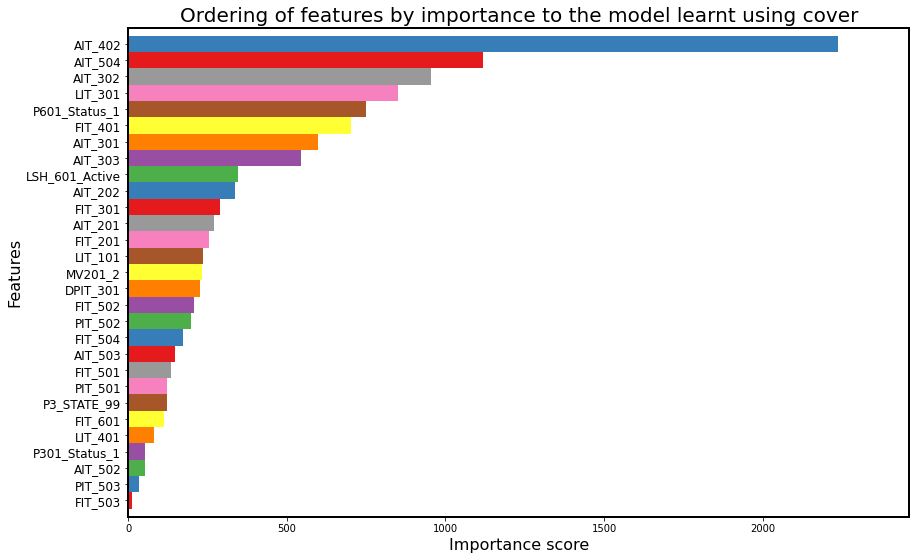

In [215]:
#VISUALISATION DES RESULTATS
from xgboost import plot_importance,  plot_tree

#Affichage de l'importance des colonnes selon le cover
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0,1,9))
ax = plot_importance(clf, height=1, color=colours, grid=False, \
                     show_values=False, importance_type='cover', ax=ax)

for axis in ['top', 'bottom', 'left', 'right']:
  ax.spines[axis].set_linewidth(2)

ax.set_xlabel('Importance score', size=16);
ax.set_ylabel('Features', size=16);
ax.set_yticklabels(ax.get_yticklabels(), size=12);
ax.set_title('Ordering of features by importance to the model learnt ' \
             'using cover', size=20);

###Gain

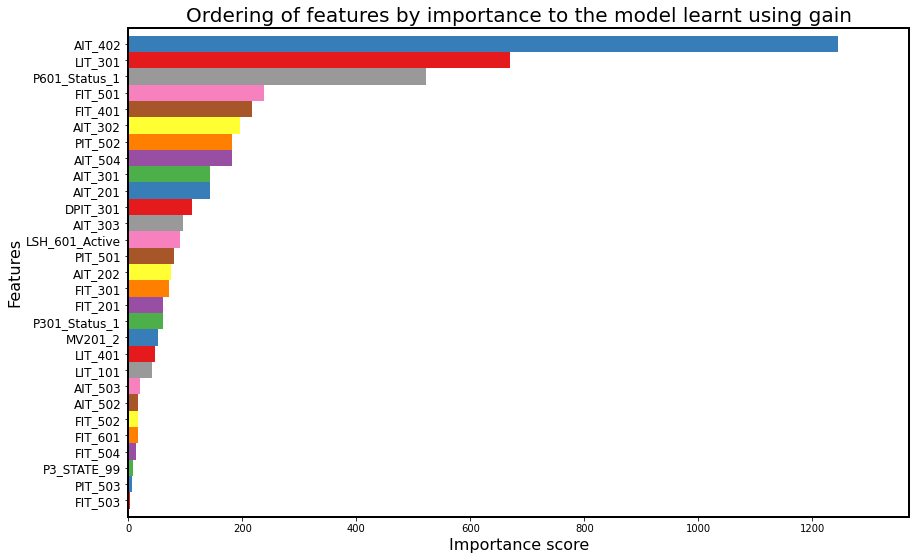

In [216]:
#Affichage de l'importance des colonnes selon le gain
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0,1,9))
ax = plot_importance(clf, height=1, color=colours, grid=False, \
                     show_values=False, importance_type='gain', ax=ax)

for axis in ['top', 'bottom', 'left', 'right']:
  ax.spines[axis].set_linewidth(2)

ax.set_xlabel('Importance score', size=16);
ax.set_ylabel('Features', size=16);
ax.set_yticklabels(ax.get_yticklabels(), size=12);
ax.set_title('Ordering of features by importance to the model learnt ' \
             'using gain', size=20);

###Weight

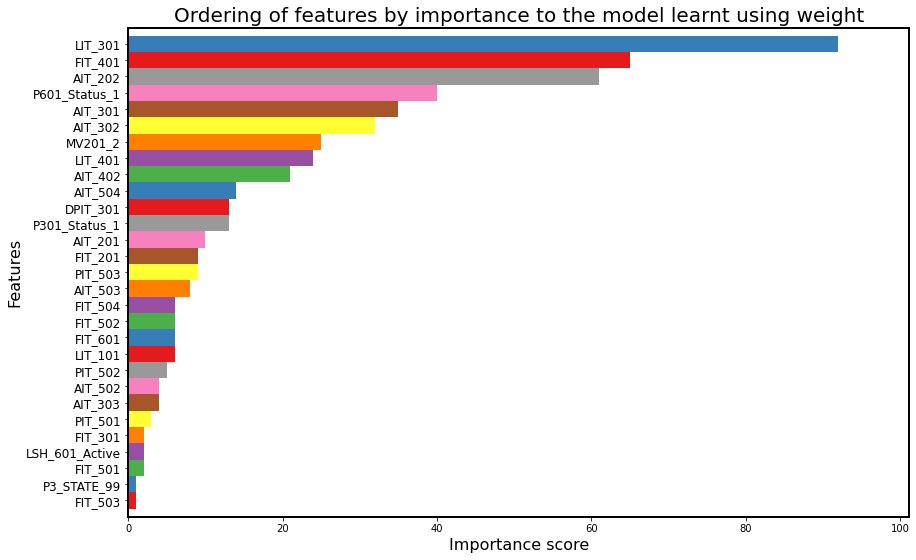

In [217]:
#Affichage de l'importance des colonnes selon le weight
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0,1,9))
ax = plot_importance(clf, height=1, color=colours, grid=False, \
                     show_values=False, importance_type='weight', ax=ax)

for axis in ['top', 'bottom', 'left', 'right']:
  ax.spines[axis].set_linewidth(2)

ax.set_xlabel('Importance score', size=16);
ax.set_ylabel('Features', size=16);
ax.set_yticklabels(ax.get_yticklabels(), size=12);
ax.set_title('Ordering of features by importance to the model learnt ' \
             'using weight', size=20);

### Tree

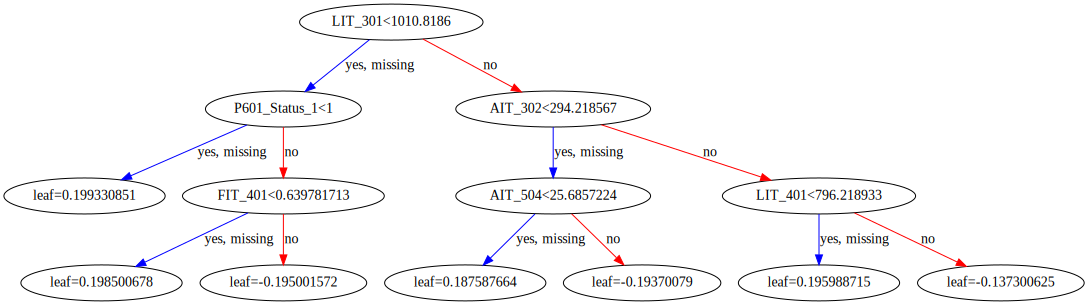

In [219]:
from xgboost import to_graphviz
to_graphviz(clf)

###Interpretation

In [ ]:
#D'après ces résultats, nous pouvons conclure que l'attribut qui influence 
#le plus grand nombre de prédictions (cover) est AIT 402 qui correspond à 
#l'analyseur de NaHSO3 et de NaOCl dans la partie P4 du système de traitement.
#L'attribut le plus important et le plus discriminant (gain) pour les 
#prédictions est aussi AIT 402.
#L'attribut qui est utilisé dans le plus grand nombre de splits dans les 
#arbres de décision crées par XGBoost (weight) est LIT 301, qui correspond au 
#detecteur de niveau d'eau dans le UF feed tank de la partie P3 du système
#de traitement.

#Donc pour améliorer la sécurité du système, il faudrait idéalement regarder de 
#plus près et avec plus de soin les attributs AIT 402 et LIT 301.

#Plot des données en 3D

In [220]:
import matplotlib.lines as mlines

def show3D_data(X, Y, x_axis_name, y_axis_name, z_axis_name):
  x=x_axis_name
  y=y_axis_name
  z=z_axis_name
  zOffset = 0.02
  limit=len(X)

  sns.reset_orig() 

  fig = plt.figure(figsize=(10,12))
  ax = fig.add_subplot(111,projection='3d')
  ax.scatter(X.loc[Y['isAttack']=='0',x][:limit],\
             X.loc[Y['isAttack']=='0',y][:limit], \
             -np.log10(X.loc[Y['isAttack']=='0',z][:limit]+zOffset),\
             c='g', marker='.', s=1, label='genuine')
  ax.scatter(X.loc[Y['isAttack']=='1',x][:limit],\
             X.loc[Y['isAttack']=='1',y][:limit],\
             -np.log10(X.loc[Y['isAttack']=='1',z][:limit] + zOffset),\
             c='r', marker='.', s=1, label='anomalies')
  ax.set_xlabel(x,size=16);
  ax.set_ylabel(y, size=16);
  ax.set_zlabel('- log$_{10}$ (' +z+ ')', size=16)
  ax.set_title('Plot of genuine data and anomalies base on 3 properties',\
               size=20)

  plt.axis('tight')
  ax.grid(1)

  noAnomalyMaker = mlines.Line2D([], [], linewidth=0, color='g', marker='.',\
                               markersize=10, label='genuine')
  anomalyMaker = mlines.Line2D([], [], linewidth=0, color='r', marker='.',\
                             markersize=10, label='anomalies')
  
  plt.legend(handles=[noAnomalyMaker, anomalyMaker], \
             bbox_to_anchor=(1.20, 0.38), frameon=False, prop={'size':16});

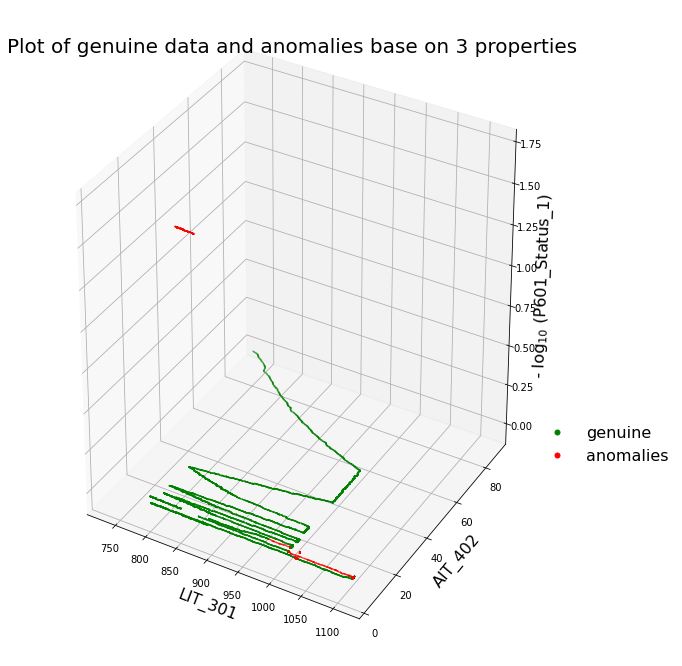

In [222]:
show3D_data(X,Y,'LIT_301','AIT_402', 'P601_Status_1')

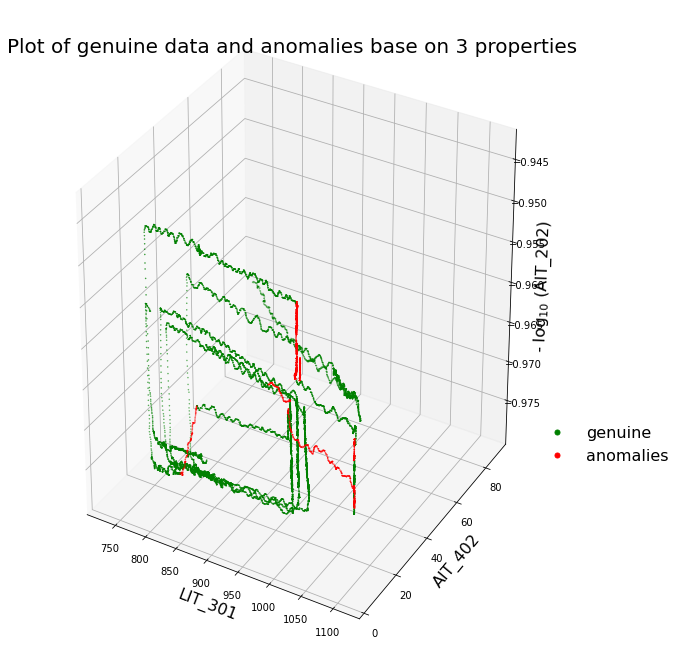

In [226]:
#plot d'autres attributs importants
show3D_data(X,Y,'LIT_301','AIT_402', 'AIT_202')